# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.

## 🌐 Connect Colab to Google Drive

In [40]:
#from google.colab import drive

#drive.mount("/gdrive")
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [41]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as plc
import seaborn as sns
from keras.saving import register_keras_serializable

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [42]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

# Set weight decay for AdamW
WEIGHT_DECAY = 1e-4

# Define the latent dimension for dimensionality reduction or feature extraction
LATENT_DIM = 64

## ⏳ Load the Data

In [43]:
data = np.load("/kaggle/input/input-dataset-hw2/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [44]:
# Normalise pixel values to range [0, 1]
X_train = (X_train[..., np.newaxis].astype(np.float32)) / 255.0
X_test = (X_test[..., np.newaxis].astype(np.float32)) / 255.0

In [45]:
# Delete aliens images from the dataset
matching_indices = []
aliens = 0
new_indices = []
for i, label in enumerate(y_train):  # i è l'indice, label è il valore
    if np.all(label == y_train[62]):
        matching_indices.append(i)
        aliens += 1
    else:
        new_indices.append(i)

print("There are ", aliens, "aliens")
print("Indexes of labels equals to the 63th:\n", matching_indices)

X_train = X_train[new_indices]
y_train = y_train[new_indices]

print(f"Training new X_train shape: {X_train.shape}")
print(f"Training new y_train shape: {y_train.shape}")

There are  110 aliens
Indexes of labels equals to the 63th:
 [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
Training new X_train shape: (2505, 64, 128, 1)
Training new y_train shape: (2505, 64, 128)


Splitting data...
Data splitted!

Number of images:
Train: 2205
Validation: 300

Number of images after augmentation:
Train: 4381
Validation: 300


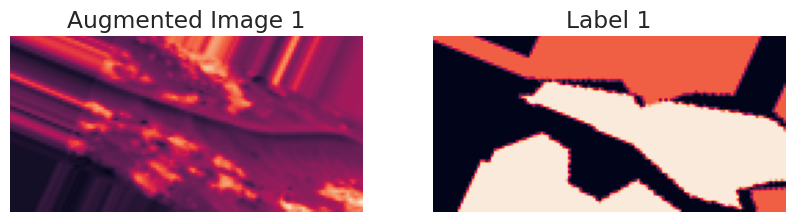

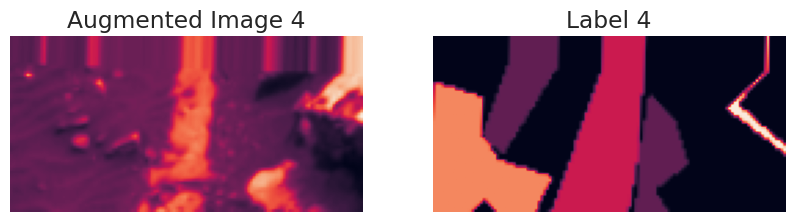

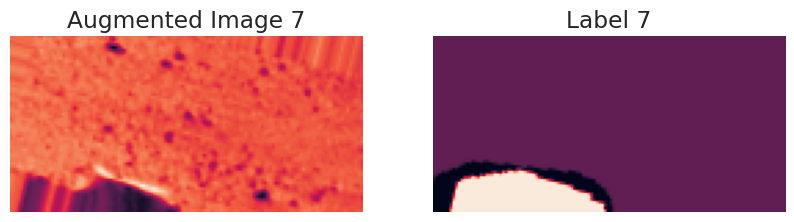

In [46]:
#split the data
print("Splitting data...")

train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train, y_train, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")

train_img_2 = train_img
train_lbl_2 = train_lbl

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Parametri di data augmentation
augmentation_params = {
    'rotation_range': 30,  # Rotazione casuale tra -30° e +30°
    'width_shift_range': 0.2,  # Traslazione orizzontale
    'height_shift_range': 0.2,  # Traslazione verticale
    'shear_range': 0.2,  # Distorsione
    'zoom_range': 0.2,  # Zoom casuale
    'horizontal_flip': True,  # Flip orizzontale
    'fill_mode': 'nearest'  # Modalità di riempimento dei pixel
}

# Aggiungi il canale alle label
train_lbl_2 = np.expand_dims(train_lbl_2, axis=-1)  # Ora le label hanno forma (2205, 64, 128, 1)

# Crea il generatore di immagini con i parametri di augmentation
image_datagen = ImageDataGenerator(**augmentation_params)
label_datagen = ImageDataGenerator(**augmentation_params)  # Stesse trasformazioni per le label

# Fit necessario solo per alcune trasformazioni
image_datagen.fit(train_img_2)
label_datagen.fit(train_lbl_2)

# Inizializza i generatori per immagini e label
image_gen = image_datagen.flow(train_img_2, batch_size=32, seed=42)
label_gen = label_datagen.flow(train_lbl_2, batch_size=32, seed=42)

# Numero di immagini da generare
num_images_to_generate = len(train_img_2)

# Liste per le immagini e label augmentate
augmented_train_img = []
augmented_train_lbl = []

# Genera immagini e label augmentate in batch
for i in range(num_images_to_generate // 32):
    img_batch = next(image_gen)
    lbl_batch = next(label_gen)
    
    augmented_train_img.append(img_batch)
    augmented_train_lbl.append(lbl_batch)

# Concatenare le immagini aumentate
augmented_train_img = np.concatenate(augmented_train_img, axis=0)
augmented_train_lbl = np.concatenate(augmented_train_lbl, axis=0)

# Rimuovi la dimensione aggiuntiva dalle label augmentate
augmented_train_lbl = np.squeeze(augmented_train_lbl, axis=-1)

# Concatenare le immagini originali e aumentate
train_img_final = np.concatenate([train_img, augmented_train_img], axis=0)
train_lbl_final = np.concatenate([train_lbl, augmented_train_lbl], axis=0)


print(f"\nNumber of images after augmentation:")
print(f"Train: {len(train_img_final)}")
print(f"Validation: {len(val_img)}")

train_img = train_img_final
train_lbl = train_lbl_final

for i in range(3):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(augmented_train_img[i*3])
    plt.title(f"Augmented Image {i*3+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)  # Secondo pannello
    plt.imshow(augmented_train_lbl[i*3])  # Mostra la label (se è un'immagine)
    plt.title(f"Label {i*3+1}")
    plt.axis('off')  # Disabilita gli assi

    plt.show()

In [47]:
def load_single_image(image_np, label_np, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    #image = tf.io.read_file(image_path)
    #image = tf.io.decode_png(image, channels=3)  # Ensure 3 channels
    #image = tf.image.resize(image, input_size)   # Resize to fixed size
    #image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    #label = tf.io.read_file(label_path)
    #label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    #label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    #label = tf.cast(label, tf.int32)
    image = tf.convert_to_tensor(image_np, dtype=tf.float32)
    label = tf.convert_to_tensor(label_np, dtype=tf.int32)

    # Resize the image and normalize it to range [0, 1]
    #IN TEORIA LO SI FA GIà
    #image = tf.image.resize(image, input_size) / 255.0

    # Resize the label to match the input size (integer values)
    #label = tf.image.resize(label, input_size, method='nearest')  # Ensure integer scaling
    label = tf.cast(label, tf.int32)

    return image, label

In [48]:
category_map={0:0,1:1,2:2,3:3,4:4}

def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [49]:


def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Convert NumPy arrays to a memory-efficient TensorFlow Dataset.

    Args:
        X (np.ndarray): Array of input images.
        y (np.ndarray): Array of labels.
        shuffle (bool): Whether to shuffle the dataset.
        augment (bool): Whether to apply data augmentation.
        seed (int): Seed for shuffling (if shuffle is True).

    Returns:
        tf.data.Dataset: Prepared TensorFlow dataset.
    """
    # Create a Dataset from NumPy arrays
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    
    # Shuffle the dataset if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X), seed=seed)
    
    # Define data augmentation function
    def augment_fn(image, label):
        #image = tf.image.random_flip_left_right(image)  # Example: Random horizontal flip
        #image = tf.image.random_brightness(image, max_delta=0.1)  # Adjust brightness
        return image, label

    # Apply data augmentation if requested
    if augment:
        dataset = dataset.map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch the dataset for better memory efficiency
    dataset = dataset.batch(batch_size,drop_remainder=False)  # Adjust batch size as needed
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize pipeline performance
    
    return dataset


In [50]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


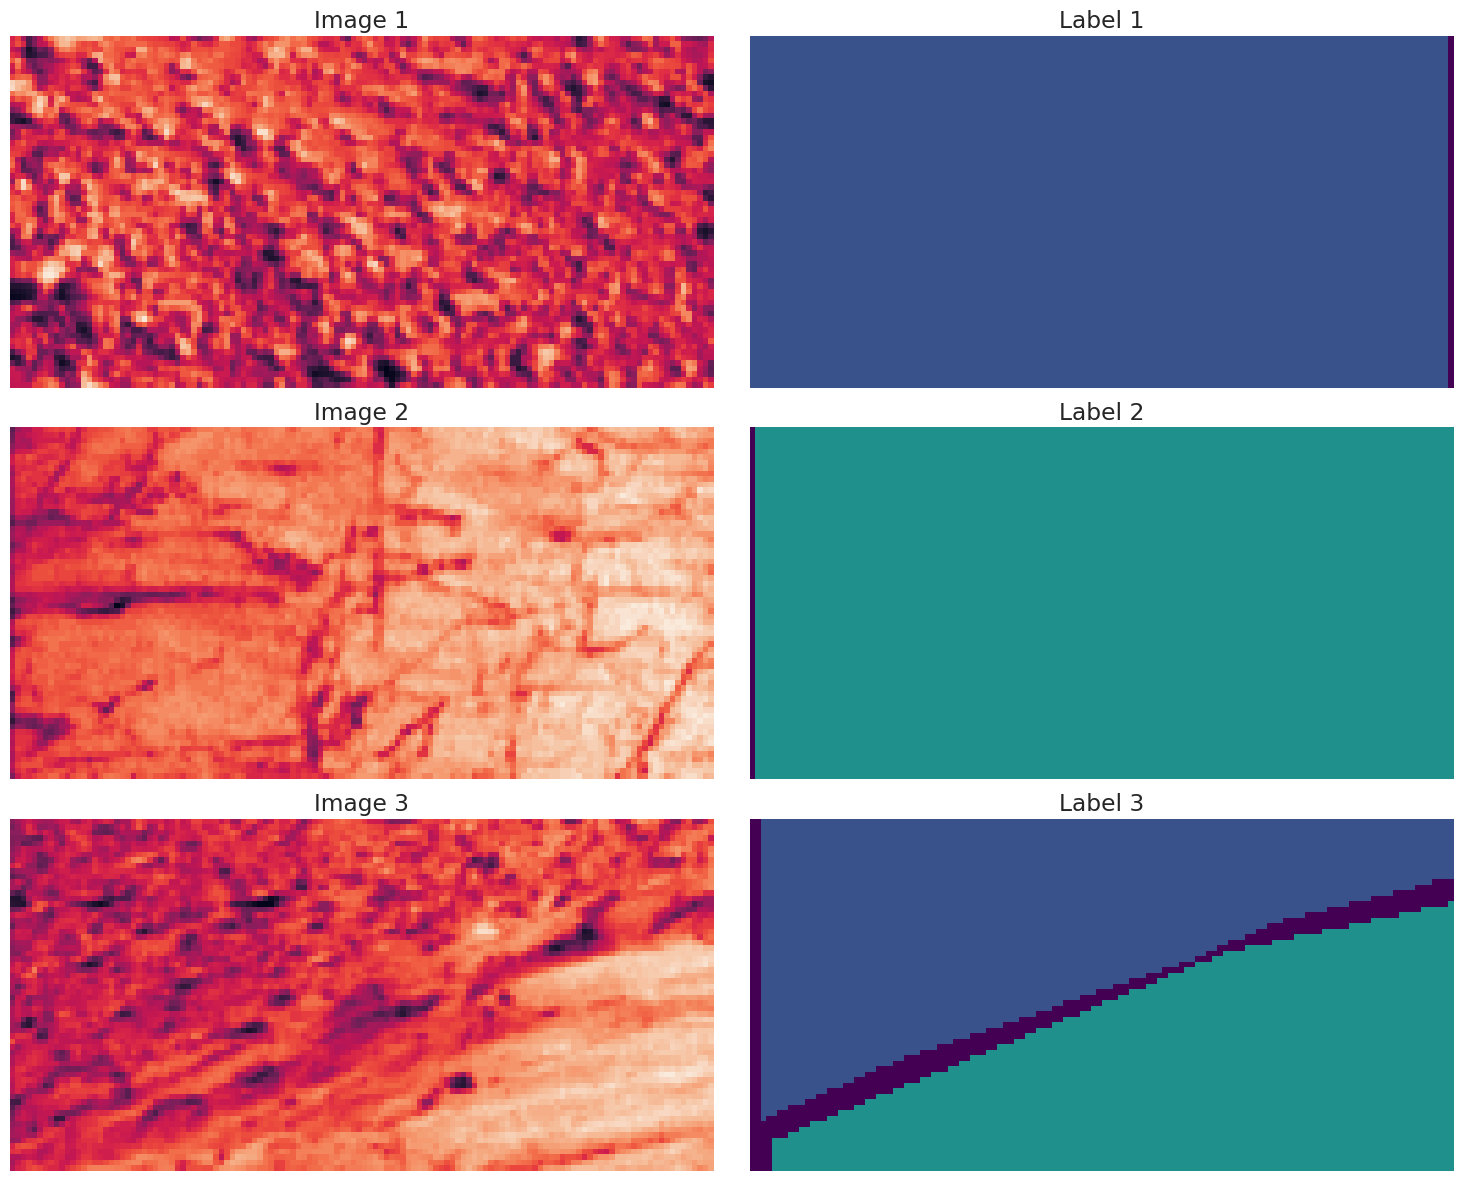

In [51]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

## 🛠️ Train and Save the Model

In [52]:
NUM_CLASSES=len(np.unique(y_train))

## UNet

In [53]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [54]:
def get_unet_model(input_shape=input_shape, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')
    
    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')
    
    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

## UNet++

In [55]:
def get_unetpp_model(input_shape=input_shape, num_classes=NUM_CLASSES, deep_supervised=False):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x00 = unetpp_block(input_layer, 32, name='00_')
    x00 = tfkl.MaxPooling2D()(x00)

    x10 = unetpp_block(x00, 64, name='10_')
    x10 = tfkl.MaxPooling2D()(x10)

    x20 = unetpp_block(x10, 128, name='20_')
    x20 = tfkl.MaxPooling2D()(x20)

    x30 = unetpp_block(x20, 256, name='30_')
    x30 = tfkl.MaxPooling2D()(x30)
    
    x40 = unetpp_block(x30, 512, name='40_')
    x40 = tfkl.MaxPooling2D()(x40)

    # Concatenate
    x01 = tfkl.UpSampling2D()(x10)
    x01 = tfkl.Concatenate()([x01, x00])
    x01 = unetpp_block(x01, 32, name='x01_')

    x11 = tfkl.UpSampling2D()(x20)
    x11 = tfkl.Concatenate()([x11, x10])
    x11 = unetpp_block(x11, 64, name='x11_')

    x21 = tfkl.UpSampling2D()(x30)
    x21 = tfkl.Concatenate()([x21, x20])
    x21 = unetpp_block(x21, 128, name='x21_')
    
    x31 = tfkl.UpSampling2D()(x40)
    x31 = tfkl.Concatenate()([x31, x30])
    x31 = unetpp_block(x31, 256, name='x31_')

    x02 = tfkl.UpSampling2D()(x11)
    x02 = tfkl.Concatenate()([x02, x01, x00])
    x02 = unetpp_block(x02, 32, name='x02_')

    x12 = tfkl.UpSampling2D()(x21)
    x12 = tfkl.Concatenate()([x12, x11, x10])
    x12 = unetpp_block(x12, 64, name='x12_')
    
    x22 = tfkl.UpSampling2D()(x31)
    x22 = tfkl.Concatenate()([x22, x21, x20])
    x22 = unetpp_block(x22, 128, name='x22_')

    x03 = tfkl.UpSampling2D()(x12)
    x03 = tfkl.Concatenate()([x03, x02, x01, x00])
    x03 = unetpp_block(x03, 32, name='x03_')
    
    x13 = tfkl.UpSampling2D()(x22)
    x13 = tfkl.Concatenate()([x13, x12, x11, x10])
    x13 = unetpp_block(x13, 64, name='x13_')
    
    x04 = tfkl.UpSampling2D()(x13)
    x04 = tfkl.Concatenate()([x04, x03, x02, x01, x00])
    x04 = unetpp_block(x04, 32, name='x04_')

    # Output layer
    if deep_supervised:
        x01 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer01')(x01)
        x02 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer02')(x02)
        x03 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer03')(x03)

        output_layer = tfkl.Average()([x01, x02, x03])
    else:
        # Upsample to ensure the output matches target spatial dimensions
        x04 = tfkl.UpSampling2D(size=(2, 2))(x04)
        output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(x04)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNetpp')

    return model

In [56]:
def get_Xy(dataset):
    X = []
    y = []
  
    # Itera su tutto il dataset
    for images, labels in dataset:
        X.append(images.numpy())
        y.append(labels.numpy())

    # Concatena i batch in array completi
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y  

X_train, y_train = get_Xy(train_dataset)
X_val, y_val  = get_Xy(val_dataset)

In [57]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras import layers
from tensorflow.keras.saving import register_keras_serializable


# valutare
# Pyramid Attention Network (PAN)
# BiFPN (Bidirectional Feature Pyramid Network)


import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


@register_keras_serializable()
class ResizeToMatch(Layer):
    def __init__(self, **kwargs):
        super(ResizeToMatch, self).__init__(**kwargs)

    def call(self, inputs):
        tensor_to_resize, reference_tensor = inputs
        target_shape = tf.shape(reference_tensor)[1:3]
        return tf.image.resize(tensor_to_resize, size=target_shape, method='bilinear')

    def get_config(self):
        config = super(ResizeToMatch, self).get_config()
        return config


def pan_block(features, filters, name="pan"):
    """Path Aggregation Network (PAN) Block"""
    features = features[::-1]  # Process from deepest to shallowest
    pyramid_features = []

    # Start with the deepest feature map
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + '_lateral_0')(features[0])
    pyramid_features.append(x)

    for i, feature in enumerate(features[1:], 1):
        # Upsample current feature map
        x = tfkl.UpSampling2D(size=(2, 2), name=name + f'_upsample_{i}')(x)

        # Align lateral feature map dimensions to match the upsampled feature map
        lateral = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + f'_lateral_{i}')(feature)

        # lateral_resized = tfkl.Lambda(
        #     lambda args: tf.image.resize(args[0], tf.shape(args[1])[1:3], method='bilinear'),
        #     name=name + f'_resize_{i}'
        # )([lateral, x])
        lateral_resized = ResizeToMatch(name=name + f'_resize_{i}')([lateral, x])


        # Combine upsampled feature map and lateral feature map
        x = tfkl.Add(name=name + f'_add_{i}')([x, lateral_resized])
        pyramid_features.append(x)

    # Reverse the order back to match the encoder's
    return pyramid_features[::-1]


@register_keras_serializable()
class SqueezeAndExcitation(tf.keras.layers.Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SqueezeAndExcitation, self).__init__(**kwargs)
        self.ratio = ratio  # Inizializza il parametro ratio

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()

        # Excitation step (fully connected layers)
        self.fc1 = tf.keras.layers.Dense(
            self.channels // self.ratio,
            activation='relu',
            kernel_initializer='he_normal'
        )
        self.fc2 = tf.keras.layers.Dense(
            self.channels,
            activation='sigmoid',
            kernel_initializer='he_normal'
        )

    def call(self, inputs):
        # Squeeze step
        x = self.global_avg_pool(inputs)
        x = tf.keras.layers.Reshape((1, 1, self.channels))(x)

        # Excitation step
        x = self.fc1(x)
        x = self.fc2(x)

        # Scale the input tensor
        return inputs * x



def unetpp_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    x = SqueezeAndExcitation()(x)

    # Return the transformed tensor
    return x


def get_unetpp_with_pan_and_se(input_shape=(64, 128, 1), num_classes=5, deep_supervised=False):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder
    x00 = unetpp_block(input_layer, 32, name='00_')
    x00 = tfkl.MaxPooling2D()(x00)

    x10 = unetpp_block(x00, 64, name='10_')
    x10 = tfkl.MaxPooling2D()(x10)
    x10 = tfkl.Dropout(0.3)(x10)

    x20 = unetpp_block(x10, 128, name='20_')
    x20 = tfkl.MaxPooling2D()(x20)
    x20 = tfkl.Dropout(0.5)(x20)

    x30 = unetpp_block(x20, 256, name='30_')
    x30 = tfkl.MaxPooling2D()(x30)
    x30 = tfkl.Dropout(0.5)(x30)

    x40 = unetpp_block(x30, 512, name='40_')
    x40 = tfkl.MaxPooling2D()(x40)
    x40 = tfkl.Dropout(0.5)(x40)

    print("Dimensioni iniziali encoder:")
    print("x00 shape:", x00.shape)
    print("x10 shape:", x10.shape)
    print("x20 shape:", x20.shape)
    print("x30 shape:", x30.shape)
    print("x40 shape:", x40.shape)

    # PAN Integration (replace FPN with PAN)
    pan_features = pan_block([x00, x10, x20, x30, x40], filters=32, name="pan")

    print("Dimensioni dopo PAN:")
    for i, feature in enumerate(pan_features):
        print(f"pan_features[{i}] shape:", feature.shape)

    # Decoder with U-Net++ dense connections
    x01 = tfkl.UpSampling2D()(x10)
    x01 = tfkl.Concatenate()([x01, pan_features[0]])
    x01 = unetpp_block(x01, 32, name='x01_')

    x11 = tfkl.UpSampling2D()(x20)
    x11 = tfkl.Concatenate()([x11, pan_features[1]])
    x11 = unetpp_block(x11, 64, name='x11_')

    x21 = tfkl.UpSampling2D()(x30)
    x21 = tfkl.Concatenate()([x21, pan_features[2]])
    x21 = unetpp_block(x21, 128, name='x21_')

    x31 = tfkl.UpSampling2D()(x40)
    x31 = tfkl.Concatenate()([x31, pan_features[3]])
    x31 = unetpp_block(x31, 256, name='x31_')
    x31 = tfkl.Dropout(0.5)(x31)

    x02 = tfkl.UpSampling2D()(x11)
    x02 = tfkl.Concatenate()([x02, pan_features[0], x01])
    x02 = unetpp_block(x02, 32, name='x02_')

    x12 = tfkl.UpSampling2D()(x21)
    x12 = tfkl.Concatenate()([x12, pan_features[1], x11])
    x12 = unetpp_block(x12, 64, name='x12_')
    x12 = tfkl.Dropout(0.5)(x12)

    x22 = tfkl.UpSampling2D()(x31)
    x22 = tfkl.Concatenate()([x22, pan_features[2], x21])
    x22 = unetpp_block(x22, 128, name='x22_')
    x22 = tfkl.Dropout(0.3)(x22)

    x03 = tfkl.UpSampling2D()(x12)
    x03 = tfkl.Concatenate()([x03, pan_features[0], x02, x01])
    x03 = unetpp_block(x03, 32, name='x03_')

    x13 = tfkl.UpSampling2D()(x22)
    x13 = tfkl.Concatenate()([x13, pan_features[1], x12, x11])
    x13 = unetpp_block(x13, 64, name='x13_')

    x04 = tfkl.UpSampling2D()(x13)
    x04 = tfkl.Concatenate()([x04, pan_features[0], x03, x02, x01])
    x04 = unetpp_block(x04, 32, name='x04_')

    print("Dimensioni decoder:")
    print("x01 shape:", x01.shape)
    print("x11 shape:", x11.shape)
    print("x21 shape:", x21.shape)
    print("x31 shape:", x31.shape)
    print("x02 shape:", x02.shape)
    print("x12 shape:", x12.shape)
    print("x22 shape:", x22.shape)
    print("x03 shape:", x03.shape)
    print("x13 shape:", x13.shape)
    print("x04 shape:", x04.shape)

    # Output layer
    if deep_supervised:
        x01 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer01')(x01)
        x02 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer02')(x02)
        x03 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer03')(x03)

        output_layer = tfkl.Average()([x01, x02, x03])
    else:
        # Upsample to ensure the output matches target spatial dimensions
        x04 = tfkl.UpSampling2D(size=(2, 2))(x04)
        output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(x04)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNetpp_with_PAN_and_SE')

    return model


def fpn_block(features, filters, name="fpn"):
    """Feature Pyramid Network (FPN) Block"""
    # Reverse the features to process from deepest to shallowest
    features = features[::-1]
    pyramid_features = []

    # Initialize pyramid with the deepest feature map
    x = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + '_lateral_0')(features[0])
    pyramid_features.append(x)

    # Build the pyramid by combining upsampled and lateral features
    for i, feature in enumerate(features[1:], 1):
        x = tfkl.UpSampling2D(size=(2, 2), name=name + f'_upsample_{i}')(x)
        lateral = tfkl.Conv2D(filters, kernel_size=1, padding='same', name=name + f'_lateral_{i}')(feature)
        x = tfkl.Add(name=name + f'_add_{i}')([x, lateral])
        pyramid_features.append(x)

    # Reverse back the pyramid to match the original order
    pyramid_features = pyramid_features[::-1]
    return pyramid_features

def get_unetpp_with_fpn(input_shape=(64, 128, 1), num_classes=5, deep_supervised=False):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Encoder
    x00 = unetpp_block(input_layer, 32, name='00_')
    x00 = tfkl.MaxPooling2D()(x00)

    x10 = unetpp_block(x00, 64, name='10_')
    x10 = tfkl.MaxPooling2D()(x10)
    x10 = tfkl.Dropout(0.3)(x10)

    x20 = unetpp_block(x10, 128, name='20_')
    x20 = tfkl.MaxPooling2D()(x20)
    x20 = tfkl.Dropout(0.5)(x20)

    x30 = unetpp_block(x20, 256, name='30_')
    x30 = tfkl.MaxPooling2D()(x30)
    x30 = tfkl.Dropout(0.5)(x30)

    x40 = unetpp_block(x30, 512, name='40_')
    x40 = tfkl.MaxPooling2D()(x40)
    x40 = tfkl.Dropout(0.5)(x40)

    print("dimensioni layer:")
    print("x00 shape:", x00.shape)
    print("x10 shape:", x10.shape)
    print("x20 shape:", x20.shape)
    print("x30 shape:", x30.shape)
    print("x40 shape:", x40.shape)

    # FPN Integration
    fpn_features = fpn_block([x00, x10, x20, x30, x40], filters=32, name="fpn")

    print("dimensioni layer dopo fpn_features:")
    print("x00 shape:", x00.shape)
    print("x10 shape:", x10.shape)
    print("x20 shape:", x20.shape)
    print("x30 shape:", x30.shape)
    print("x40 shape:", x40.shape)

    
    # Decoder with U-Net++ dense connections
    x01 = tfkl.UpSampling2D()(x10)
    x01 = tfkl.Concatenate()([x01, fpn_features[0]])
    x01 = unetpp_block(x01, 32, name='x01_')

    x11 = tfkl.UpSampling2D()(x20)
    x11 = tfkl.Concatenate()([x11, fpn_features[1]])
    x11 = unetpp_block(x11, 64, name='x11_')

    x21 = tfkl.UpSampling2D()(x30)
    x21 = tfkl.Concatenate()([x21, fpn_features[2]])
    x21 = unetpp_block(x21, 128, name='x21_')

    x31 = tfkl.UpSampling2D()(x40)
    x31 = tfkl.Concatenate()([x31, fpn_features[3]])
    x31 = unetpp_block(x31, 256, name='x31_')
    x31 = tfkl.Dropout(0.5)(x31)

    x02 = tfkl.UpSampling2D()(x11)
    x02 = tfkl.Concatenate()([x02, fpn_features[0], x01])
    x02 = unetpp_block(x02, 32, name='x02_')

    x12 = tfkl.UpSampling2D()(x21)
    x12 = tfkl.Concatenate()([x12, fpn_features[1], x11])
    x12 = unetpp_block(x12, 64, name='x12_')
    x12 = tfkl.Dropout(0.5)(x12)

    x22 = tfkl.UpSampling2D()(x31)
    x22 = tfkl.Concatenate()([x22, fpn_features[2], x21])
    x22 = unetpp_block(x22, 128, name='x22_')
    x22 = tfkl.Dropout(0.3)(x22)

    x03 = tfkl.UpSampling2D()(x12)
    x03 = tfkl.Concatenate()([x03, fpn_features[0], x02, x01])
    x03 = unetpp_block(x03, 32, name='x03_')

    x13 = tfkl.UpSampling2D()(x22)
    x13 = tfkl.Concatenate()([x13, fpn_features[1], x12, x11])
    x13 = unetpp_block(x13, 64, name='x13_')

    x04 = tfkl.UpSampling2D()(x13)
    x04 = tfkl.Concatenate()([x04, fpn_features[0], x03, x02, x01])
    x04 = unetpp_block(x04, 32, name='x04_')

    print("dimensioni layer:")
    print("x01 shape:", x01.shape)
    print("x11 shape:", x11.shape)
    print("x21 shape:", x21.shape)
    print("x31 shape:", x31.shape)
    print("x02 shape:", x02.shape)
    print("x12 shape:", x12.shape)
    print("x22 shape:", x22.shape)
    print("x03 shape:", x03.shape)
    print("x13 shape:", x13.shape)
    print("x04 shape:", x04.shape)
    print()

    # Output layer
    if deep_supervised:
        x01 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer01')(x01)
        x02 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer02')(x02)
        x03 = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer03')(x03)

        output_layer = tfkl.Average()([x01, x02, x03])
    else:
        # Upsample to ensure the output matches target spatial dimensions
        x04 = tfkl.UpSampling2D(size=(2, 2))(x04)
        output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(x04)
        
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNetpp_with_FPN')

    return model

In [58]:
# Creazione del modello
#model = get_unetpp_with_fpn(input_shape=(64, 128, 1), num_classes=5)
model = get_unetpp_with_pan_and_se(input_shape=(64, 128, 1), num_classes=5)

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, name='mean_iou', ignore_class=0, sparse_y_pred=False)

Dimensioni iniziali encoder:
x00 shape: (None, 32, 64, 32)
x10 shape: (None, 16, 32, 64)
x20 shape: (None, 8, 16, 128)
x30 shape: (None, 4, 8, 256)
x40 shape: (None, 2, 4, 512)
Dimensioni dopo PAN:
pan_features[0] shape: (None, 32, 64, 32)
pan_features[1] shape: (None, 16, 32, 32)
pan_features[2] shape: (None, 8, 16, 32)
pan_features[3] shape: (None, 4, 8, 32)
pan_features[4] shape: (None, 2, 4, 32)
Dimensioni decoder:
x01 shape: (None, 32, 64, 32)
x11 shape: (None, 16, 32, 64)
x21 shape: (None, 8, 16, 128)
x31 shape: (None, 4, 8, 256)
x02 shape: (None, 32, 64, 32)
x12 shape: (None, 16, 32, 64)
x22 shape: (None, 8, 16, 128)
x03 shape: (None, 32, 64, 32)
x13 shape: (None, 16, 32, 64)
x04 shape: (None, 32, 64, 32)


Model: "UNetpp_with_PAN_and_SE"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 00_conv1 (Conv2D) │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 00_bn1            │ (None, 64, 128, │       128 │ 00_conv1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 00_activation1    │ (None, 64, 128, │         0 │ 00_bn1[0][0]   │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 00_conv2 (Conv2D) │ (None, 64, 128, │     9,248 │ 00_activation… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 00_bn2            │ (None, 64, 128, │       128 │ 00_conv2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 00_activation2    │ (None, 64, 128, │         0 │ 00_bn2[0][0]   │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ squeeze_and_exci… │ (None, 64, 128, │       162 │ 00_activation… │   Y   │
│ (SqueezeAndExcit… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_5   │ (None, 32, 64,  │         0 │ squeeze_and_e… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 10_conv1 (Conv2D) │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 10_bn1            │ (None, 32, 64,  │       256 │ 10_conv1[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 10_activation1    │ (None, 32, 64,  │         0 │ 10_bn1[0][0]   │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 10_conv2 (Conv2D) │ (None, 32, 64,  │    36,928 │ 10_activation… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 10_bn2            │ (None, 32, 64,  │       256 │ 10_conv2[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ 10_activation2    │ (None, 32, 64,  │         0 │ 10_bn2[0][0]   │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ squeeze_and_exci… │ (None, 32, 64,  │       580 │ 10_activation… │   Y   │
│ (SqueezeAndExcit… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_6   │ (None, 16, 32,  │         0 │ squeeze_and_e… │   - 

 Total params: 8,469,431 (32.31 MB)

 Trainable params: 8,462,135 (32.28 MB)

 Non-trainable params: 7,296 (28.50 KB)

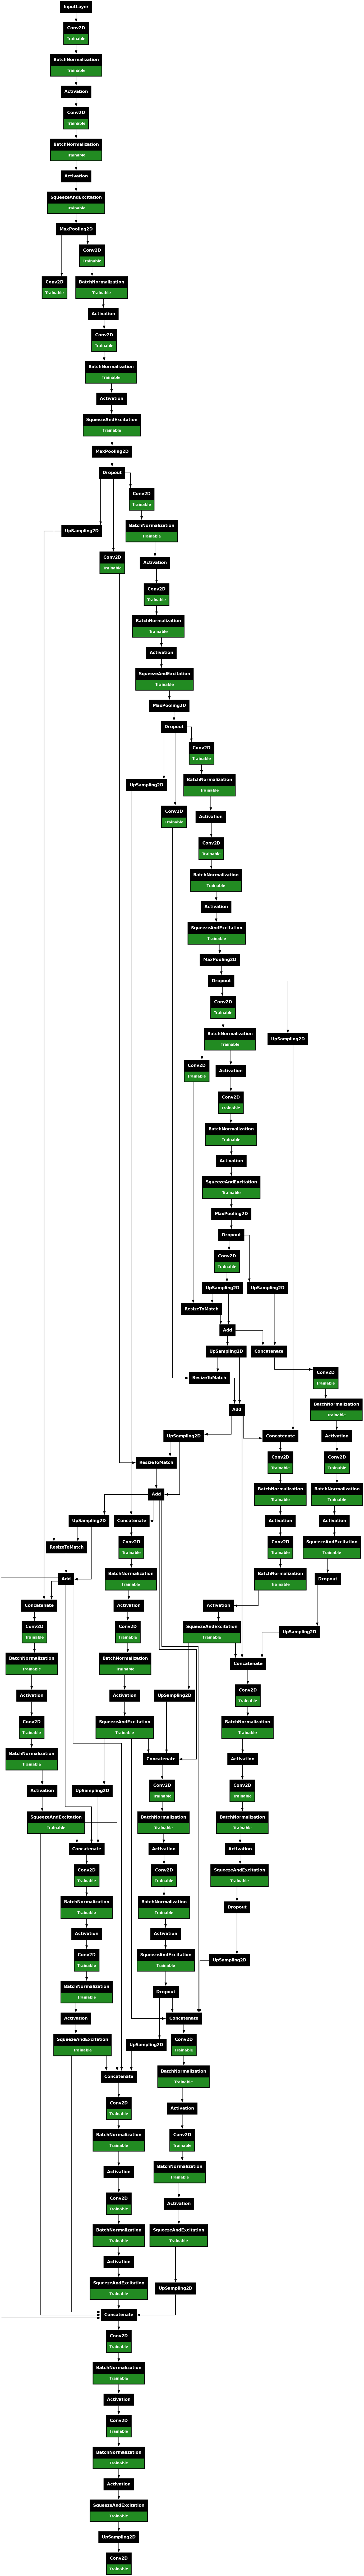

In [59]:
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [60]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=150):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [61]:
@register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    y_true_f = tf.reshape(y_true_one_hot, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


@register_keras_serializable()
def tversky_loss(y_true, y_pred, beta=0.7):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.softmax(y_pred)
    numerator = y_true * y_pred
    denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

    return 1 - tf.reduce_sum(numerator) / tf.reduce_sum(denominator)


import tensorflow as tf
from tensorflow.keras import backend as K


@register_keras_serializable()
def categorical_focal_loss(gamma=2., alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Convertiamo y_true in one-hot encoding
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])

        # Assicurati che y_pred sia compreso tra epsilon e 1 - epsilon per evitare errori numerici
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Calcola il termine di focalizzazione
        cross_entropy = -y_true_one_hot * K.log(y_pred)
        
        # Calcola p_t, che è la probabilità predetta per la classe vera
        p_t = y_true_one_hot * y_pred
        
        # Calcola la Focal Loss
        focal_loss = alpha * K.pow((K.ones_like(y_true_one_hot) - p_t), gamma) * cross_entropy
        
        return K.mean(K.sum(focal_loss, axis=-1), axis=-1)
    
    return focal_loss


@register_keras_serializable()
def iou_loss(y_true, y_pred, smooth=1e-6):
    # Assicurati che y_true sia one-hot encoded
    y_true = tf.cast(y_true, tf.int32)  # Assicurati che y_true sia un intero
    y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])  # One-hot encoding

    # Calcola l'intersezione e l'unione
    intersection = tf.reduce_sum(y_true_one_hot * y_pred, axis=[1, 2])  # Somma lungo height e width
    union = tf.reduce_sum(y_true_one_hot, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2]) - intersection

    # Calcola la IoU Loss (1 - IoU)
    iou = (intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(iou)  # Media su tutto il batch


@register_keras_serializable()
def combined_iou_focal_dice_loss(y_true, y_pred, alpha=0.4, beta=0.3, gamma=2., focal_alpha=0.25):
    # Calcolare Focal Loss
    focal_loss = categorical_focal_loss(gamma=gamma, alpha=focal_alpha)(y_true, y_pred)
    
    # Calcolare Dice Loss
    dice_loss_val = dice_loss(y_true, y_pred)
    
    # Calcolare IoU Loss
    iou_loss_val = iou_loss(y_true, y_pred)

    # Combinare le perdite
    total_loss = alpha * focal_loss + beta * dice_loss_val + (1 - alpha - beta) * iou_loss_val
    return total_loss


#@tf.function
@register_keras_serializable()
def combined_focal_dice_loss(y_true, y_pred, alpha=0.7, beta=0.3, gamma=2., focal_alpha=0.25):
    # Calcola la Focal Loss
    focal_loss = categorical_focal_loss(gamma=gamma, alpha=focal_alpha)(y_true, y_pred)

    # Calcola la Dice Loss
    dice_loss_val = dice_loss(y_true, y_pred)

    # Combinazione delle perdite
    combined_loss = alpha * focal_loss + beta * dice_loss_val
    return combined_loss


@register_keras_serializable()
def combined_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    return alpha * tfk.losses.SparseCategoricalCrossentropy()(y_true, y_pred) + beta * dice_loss(y_true, y_pred)

In [62]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=combined_focal_dice_loss,
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE, WEIGHT_DECAY),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [63]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_LR_On_Plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=30, 
    factor=0.1, 
    min_lr=1e-4
)

viz_callback = VizCallback(val_img[3], val_lbl[3])

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - accuracy: 0.4068 - loss: 0.5772 - mean_iou: 0.1757

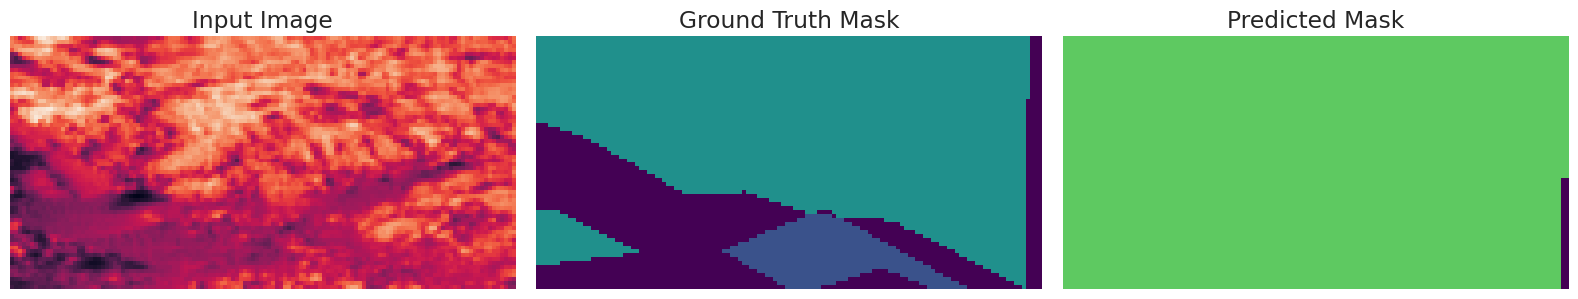

35/35 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.4086 - loss: 0.5766 - mean_iou: 0.1768 - val_accuracy: 0.2185 - val_loss: 0.8507 - val_mean_iou: 0.0571 - learning_rate: 0.0010
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.5834 - loss: 0.5043 - mean_iou: 0.2937 - val_accuracy: 0.2171 - val_loss: 0.9083 - val_mean_iou: 0.0715 - learning_rate: 0.0010
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.6212 - loss: 0.4817 - mean_iou: 0.3198 - val_accuracy: 0.2380 - val_loss: 0.7694 - val_mean_iou: 0.0428 - learning_rate: 0.0010
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.6557 - loss: 0.4606 - mean_iou: 0.3537 - val_accuracy: 0.2171 - val_loss: 1.1846 - val_mean_iou: 0.0715 - learning_rate: 0.0010
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6394 - loss: 0.4591 - mean_iou: 0.3393 - val_accuracy: 0.2171 - val_loss: 1.3369 - val_mean_iou: 0.0715 - learning_rate: 0.0010
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━

In [64]:
# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, 
               viz_callback,
               reduce_LR_On_Plateau
              ],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [65]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241213_102118.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.



In [66]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [67]:
from keras.saving import register_keras_serializable

# Carica il modello
model = tf.keras.models.load_model(
    model_filename,
    custom_objects={"ResizeToMatch": ResizeToMatch}
)

#model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from model_241213_102118.keras


In [68]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)

preds = np.where(preds == 0, 1, preds)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step
Predictions shape: (10022, 64, 128)


In [69]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [70]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)
print(f"Created {submission_filename}")

#from google.colab import files
#files.download(submission_filename)

Created submission_241213_102118.csv
